<a href="https://colab.research.google.com/github/PomazkinG/Particle/blob/master/DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Take-home lab session by Pomazkin Grigorii

Student id: 66904

Input data: images of handwritten digits rotated and not rotated

Expected output: 2 classification results - digit (e.g. 1,2,3) and rotated or not (0 or 1)

In [0]:
import numpy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.image import rot90
import pandas as pd
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout, Flatten
from matplotlib import pyplot as plt

Download and prepare MNIST dataset

In [2]:
def batch_rotate(images, indices):
    images_with_channel = images[:, :, :, numpy.newaxis]
    images_with_channel[indices] = rot90(images_with_channel[indices])
    return images_with_channel / 255.

def prepare_mnist():
    rng = numpy.random.RandomState(0)
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    rotate_train = rng.choice(2, size=x_train.shape[0]).astype(numpy.bool)
    rotate_test = rng.choice(2, size=x_test.shape[0]).astype(numpy.bool)
    x_train = batch_rotate(x_train, rotate_train)
    x_test = batch_rotate(x_test, rotate_test)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    rotate_train = rotate_train.reshape((-1, 1))
    rotate_test = rotate_test.reshape((-1, 1))
    return x_train, x_test, y_train, y_test, rotate_train, rotate_test
  
x_train, x_test, y_train, y_test, y_rot_train, y_rot_test = prepare_mnist()
y_rot_train = y_rot_train*1
y_rot_test = y_rot_test*1
print(x_train.shape, y_train.shape, y_rot_train.shape)

(60000, 28, 28, 1) (60000, 10) (60000, 1)


List of hyperparameters

In [0]:
#Input shape 28x28 (image size) + channel = 1
input_shape = [x_train.shape[1],x_train.shape[2],x_train.shape[3]]

#Batch size giving computer power = 128
batch_size = 128

#To save time number of epochs = 5
num_epoch = 5

#Optimizer ADAM
opt = keras.optimizers.Adam() 

#Loss function for digit output = categorical_crossentropy (multiclassification problem) and 
#for rotation output loss function = binary_crossentropy (binary classification problem)
losses = {"digit_output": "categorical_crossentropy", "rotation_output": "binary_crossentropy"}

**Model architecture**

1. Choose the number of neurons in the Dense layer

In [26]:
NN = 8 #number of neural nets
model = [0] * NN
model_log = [0] * NN

for j in range(NN):
  #input layer
  input_layer = Input(shape=input_shape) 

  #1st convolution-pooling pair
  Conv_1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(input_layer)
  Max_Pooling_1 = MaxPool2D()(Conv_1)

  #2nd convolution-pooling pair
  Conv_2 = Conv2D(64, (3, 3), activation='relu')(Max_Pooling_1)
  Max_Pooling_2 = MaxPool2D()(Conv_2)

  #Flattening
  Flat = Flatten()(Max_Pooling_2)

  #Dense layer
  Dense_1 = Dense(2**(j+4), activation='relu')(Flat)

  #Output layers

  #1. digit recognition
  digit_output = Dense(y_train.shape[1], activation='softmax', name = 'digit_output')(Dense_1)

  #2. rotation recognition
  rotation_output = Dense(y_rot_train.shape[1], activation='sigmoid', name = 'rotation_output')(Dense_1)

  #model compilation
  model[j] = Model(inputs=input_layer, outputs=[digit_output, rotation_output])
  model[j].compile(loss=losses,optimizer=opt,metrics=['accuracy']) #accuracy for classification problem


  model_log[j] = model[j].fit(x_train,
	{"digit_output": y_train, "rotation_output": y_rot_train},
	validation_data=(x_test,
		{"digit_output": y_test, "rotation_output": y_rot_test}),
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 41s 685us/step - loss: 0.7119 - digit_output_loss: 0.6189 - rotation_output_loss: 0.0928 - digit_output_accuracy: 0.8041 - rotation_output_accuracy: 0.9675 - val_loss: 0.2545 - val_digit_output_loss: 0.2175 - val_rotation_output_loss: 0.0346 - val_digit_output_accuracy: 0.9340 - val_rotation_output_accuracy: 0.9888
Epoch 2/5
60000/60000 [==============================] - 41s 681us/step - loss: 0.2073 - digit_output_loss: 0.1811 - rotation_output_loss: 0.0262 - digit_output_accuracy: 0.9465 - rotation_output_accuracy: 0.9909 - val_loss: 0.1675 - val_digit_output_loss: 0.1454 - val_rotation_output_loss: 0.0207 - val_digit_output_accuracy: 0.9540 - val_rotation_output_accuracy: 0.9934
Epoch 3/5
60000/60000 [==============================] - 41s 678us/step - loss: 0.1478 - digit_output_loss: 0.1280 - rotation_output_loss: 0.0198 - digit_output_accuracy: 0.9613 - rotation_output_accura

In [32]:
names = ["0N","32N","64N","128N","256N","512N","1024N","2048N"]
for j in range(NN):
  print('CNN ', names[j], 'Digit validation accuracy', round(max(model_log[j].history['val_digit_output_accuracy']),4), 
        'Rotation validation accuracy', round(max(model_log[j].history['val_rotation_output_accuracy']),4))

CNN  0N Digit validation accuracy 0.9759 Rotation validation accuracy 0.994
CNN  32N Digit validation accuracy 0.9828 Rotation validation accuracy 0.9956
CNN  64N Digit validation accuracy 0.9861 Rotation validation accuracy 0.997
CNN  128N Digit validation accuracy 0.9862 Rotation validation accuracy 0.9965
CNN  256N Digit validation accuracy 0.9877 Rotation validation accuracy 0.9968
CNN  512N Digit validation accuracy 0.9872 Rotation validation accuracy 0.9966
CNN  1024N Digit validation accuracy 0.9878 Rotation validation accuracy 0.9969
CNN  2048N Digit validation accuracy 0.9871 Rotation validation accuracy 0.9968


In [28]:
model_log[1].history

{'digit_output_accuracy': [0.9101167,
  0.97215,
  0.9788667,
  0.98336667,
  0.98648334],
 'digit_output_loss': [0.27974707,
  0.092609935,
  0.0680828,
  0.053976208,
  0.043788563],
 'loss': [0.3316314733783404,
  0.10700559714833896,
  0.07828722340663274,
  0.062034044259786605,
  0.049686952790617946],
 'rotation_output_accuracy': [0.98011667,
  0.99523336,
  0.99633336,
  0.99733335,
  0.99791664],
 'rotation_output_loss': [0.05175935,
  0.014384955,
  0.010175974,
  0.008036069,
  0.005893291],
 'val_digit_output_accuracy': [0.9686999917030334,
  0.9768000245094299,
  0.9749000072479248,
  0.9824000000953674,
  0.9828000068664551],
 'val_digit_output_loss': [0.09537819027900696,
  0.07417340576648712,
  0.07547200471162796,
  0.05880388990044594,
  0.05369741842150688],
 'val_loss': [0.118492382979393,
  0.09181085035800934,
  0.09460914820544422,
  0.07255355272460728,
  0.06772431614175439],
 'val_rotation_output_accuracy': [0.991599977016449,
  0.9944999814033508,
  0.994599

In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0]) #Test loss: 0.0296396646054
print('Test accuracy:', score[1]) #Test accuracy: 0.9904

Test loss: 0.07858740667637083
Test accuracy: 0.9824000000953674


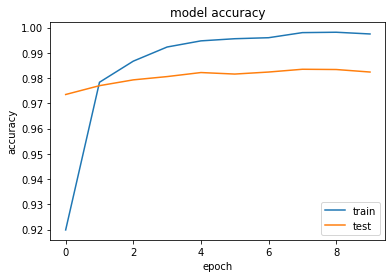

In [0]:
plt.plot(model_log.history['accuracy'])
plt.plot(model_log.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
keras.utils.plot_model(model, 'my_first_model.png', show_shapes=True)